В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [28]:
import warnings

warnings.filterwarnings("ignore")

Area under ROC score on Training dataset: 0.77%


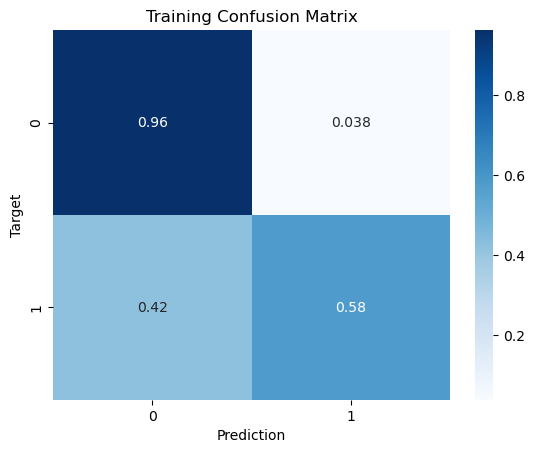

Area under ROC score on Validation dataset: 0.75%


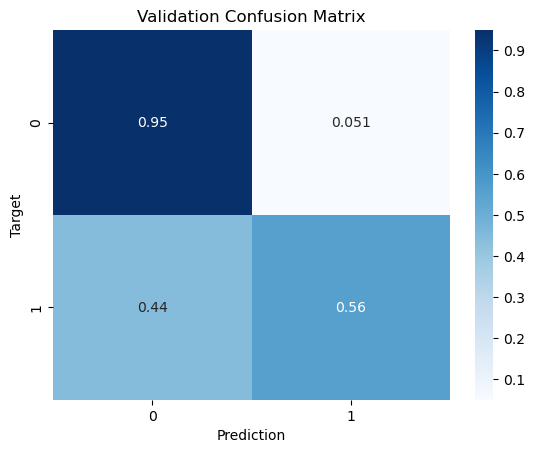

In [2]:
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=23)

# Створюємо трен. і вал. набори
input_cols = list(raw_df.columns)[:-1]
target_col = list(raw_df.columns)[-1]
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.to_list()
categorical_cols = train_inputs.select_dtypes(include='object').columns.to_list()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=23))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    # Отримання ймовірностей
    preds = model_pipeline.predict(inputs)
    
    # Обчислення ROC-кривої
    fpr, tpr, thresholds = roc_curve(targets, preds, pos_label=1)
    
    # Обчислення AUROC
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    
    #Побудова та візуалізація матриці плутанини
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
polinom = {
    'model': model_pipeline,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols
}

joblib.dump(polinom, 'data/polinom.joblib');

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [3]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()), 
    ('polynomial_features', PolynomialFeatures(degree=2))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Area under ROC score on Training dataset: 0.81%


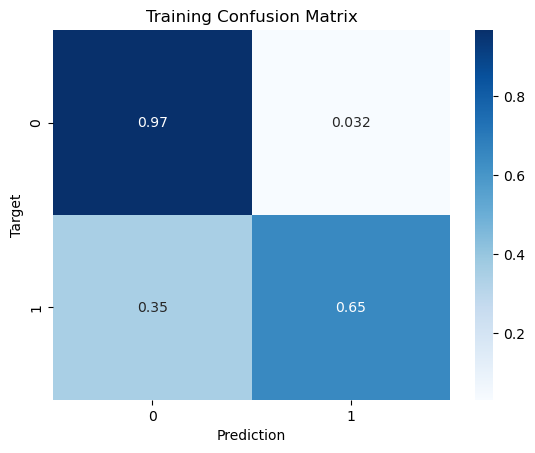

Area under ROC score on Validation dataset: 0.79%


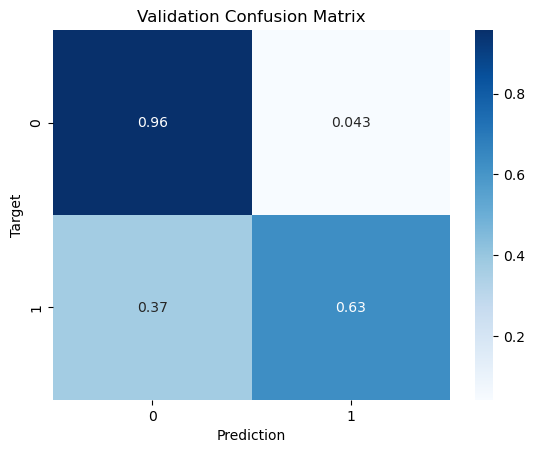

In [4]:
# Запуск пайплайну на тренування
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=23))
])

model_pipeline.fit(train_inputs, train_targets)

# Виведення метрики для тренувального і валідаційного набору
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

**Висновок:** Модель покращилась в порівнянні з попередньою. Оскільки значення Area under ROC score на навчальних та валідаційних даних близькі, то overfit чи underfit не спостерігається.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [5]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()), 
    ('polynomial_features', PolynomialFeatures(degree=4))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Area under ROC score on Training dataset: 0.84%


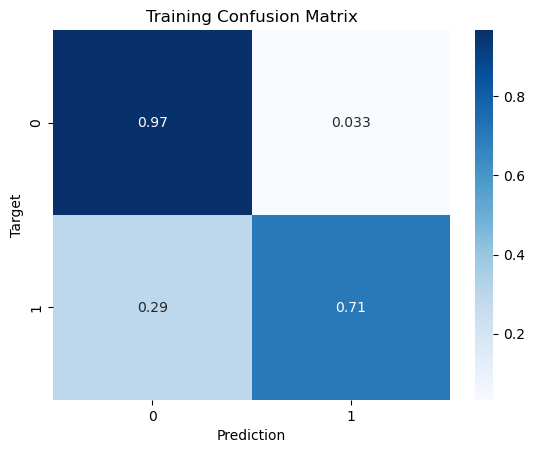

Area under ROC score on Validation dataset: 0.82%


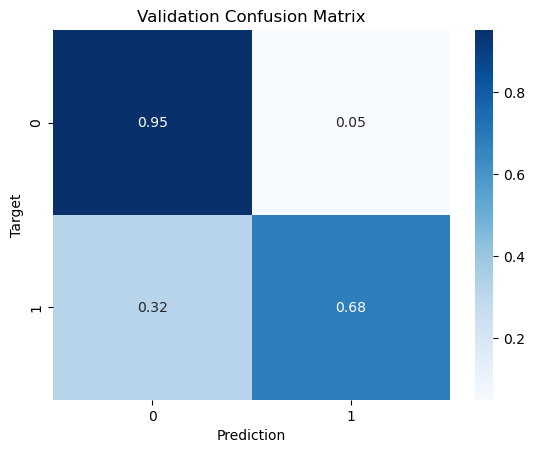

In [6]:
# Запуск пайплайну на тренування
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=23))
])

model_pipeline.fit(train_inputs, train_targets)

# Виведення метрики для тренувального і валідаційного набору
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

**Висновок**: Спостерігаю покращення результатів для обох вибірок. Overfit-у чи underfit-у із 4-им степенем немає.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [7]:
lin_df = pd.read_csv('data/regression_data.csv')

In [8]:
lin_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [9]:
lin_train_df, lin_val_df = train_test_split(lin_df, test_size=0.2, random_state=23)

In [10]:
# Створюю трен. і вал. набори
lin_input_cols = list(lin_df.columns)[:-1]
lin_target_col = list(lin_df.columns)[-1]
lin_train_inputs, lin_train_targets = lin_train_df[lin_input_cols], lin_train_df[lin_target_col]
lin_val_inputs, lin_val_targets = lin_val_df[lin_input_cols], lin_val_df[lin_target_col]

In [11]:
# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, lin_input_cols),
    ])

In [12]:
# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
lin_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearRegression())
])

In [13]:
# Тренуємо пайплайн
lin_model_pipeline.fit(lin_train_inputs, lin_train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'feature_4',
                                                   'feature_5'])])),
                ('classifier', LinearRegression())])

In [14]:
# Функція для прогнозування та обчислення метрик
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    # Obtain predictions
    preds = model_pipeline.predict(inputs)
    
    # Calculate regression metrics
    mse = mean_squared_error(targets, preds)
    mae = mean_absolute_error(targets, preds)
    r2 = r2_score(targets, preds)
    
    # Print regression metrics
    print(f"{name} набір даних: Mean Squared Error: {mse:.2f}")
    print(f"{name} набір даних: Mean Absolute Error: {mae:.2f}")
    print(f"{name} набір даних: R-squared: {r2:.2f}")
    
    # Plotting predictions vs actual values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=targets, y=preds, alpha=0.5)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'k--', lw=2)
    plt.xlabel('Дійсні Значення')
    plt.ylabel('Передбачення')
    plt.title('{} Передбачення vs Дійсні Значення'.format(name))
    plt.show()
    
    return preds

Тренувальний набір даних: Mean Squared Error: 1.05
Тренувальний набір даних: Mean Absolute Error: 0.83
Тренувальний набір даних: R-squared: 1.00


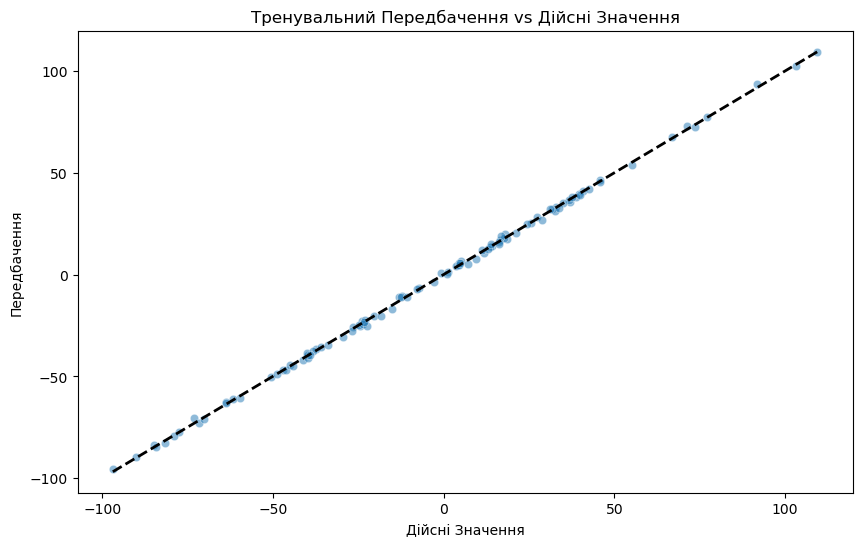

Валідаційний набір даних: Mean Squared Error: 1.11
Валідаційний набір даних: Mean Absolute Error: 0.89
Валідаційний набір даних: R-squared: 1.00


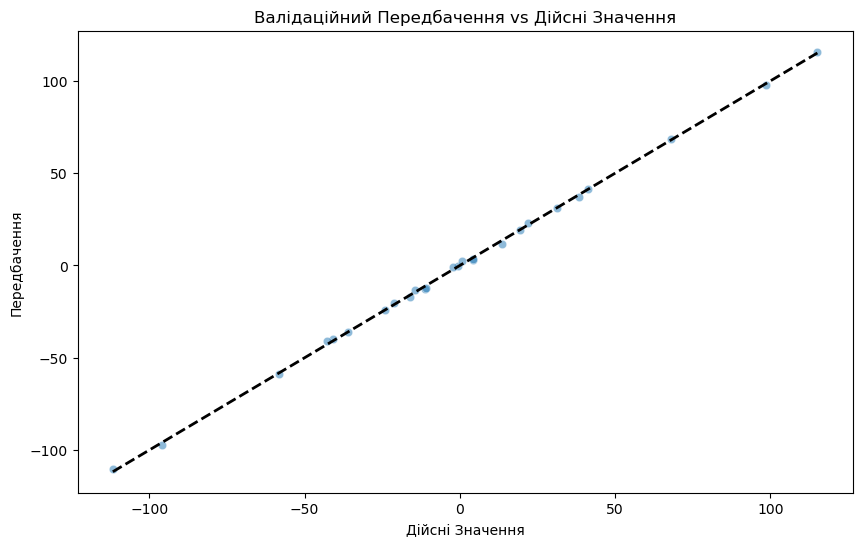

In [15]:
# Оцінюємо модель на трен і вал даних
lin_train_preds = predict_and_plot(lin_model_pipeline, lin_train_inputs, lin_train_targets, 'Тренувальний')
lin_val_preds = predict_and_plot(lin_model_pipeline, lin_val_inputs, lin_val_targets, 'Валідаційний')

**Висновок:** Mean Squared Error на обох датасетах показує ідеальний фіт. Значення MSE і MAE для обох датасетів низькі та близькі одне до одного (`навчання: MSE = 1,05, MAE = 0,83`; `перевірка: MSE = 1,11, MAE = 0,89`).
Це свідчить про те, що модель добре узагальнює.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лог регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [16]:
models = [
    Ridge(),
    Lasso(),
    ElasticNet(),
]

In [22]:
poly_features = PolynomialFeatures(degree=20)
X_train_poly = poly_features.fit_transform(lin_train_inputs)
X_val_poly = poly_features.transform(lin_val_inputs)

In [24]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
    val_metrics = mean_squared_error(y_val, y_val_pred, squared=False).round(6)

    return dict(train=train_metrics, val=val_metrics)

In [29]:
for model in models:
    model.fit(X_train_poly, lin_train_targets)
    eval_results = evaluate_model(model, X_train_poly, lin_train_targets, X_val_poly, lin_val_targets)
    print(f'{str(model)}: {eval_results}\n')

Ridge(): {'train': 39.647653, 'val': 306035.001015}

Lasso(): {'train': 2.428568, 'val': 2545.899774}

ElasticNet(): {'train': 10.005761, 'val': 3144.660467}



Ridge(): {'train': 39.647653, 'val': 306035.001015}

Прогноз та графік для Ridge() на тренувальних даних:
Тренувальні набір даних: Mean Squared Error: 1571.94
Тренувальні набір даних: Mean Absolute Error: 23.22
Тренувальні набір даних: R-squared: 0.19


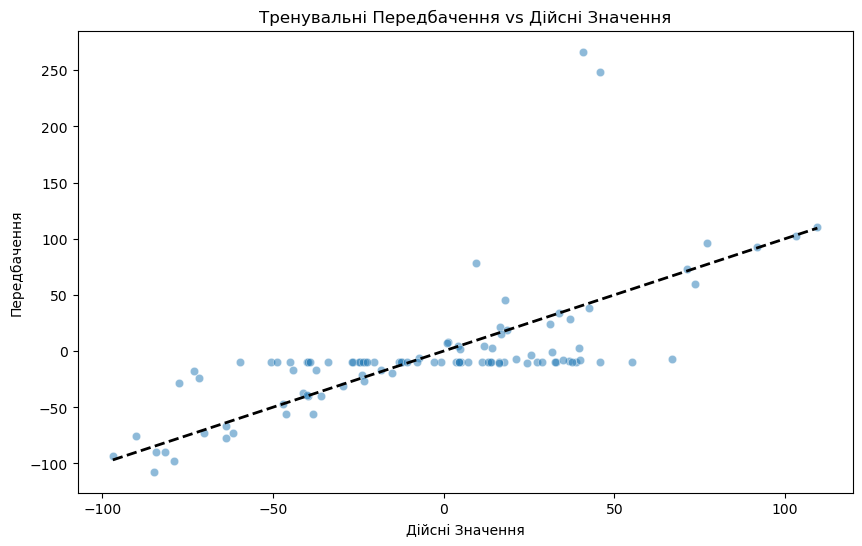

Прогноз та графік для Ridge() на валідаційних даних:
Валідаційні набір даних: Mean Squared Error: 93657421846.09
Валідаційні набір даних: Mean Absolute Error: 67957.23
Валідаційні набір даних: R-squared: -37823078.90


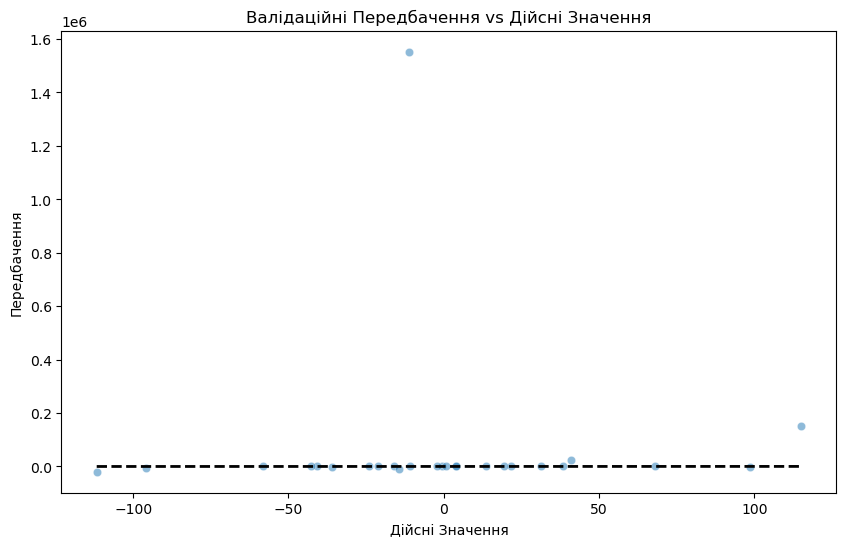

Lasso(): {'train': 2.428568, 'val': 2545.899774}

Прогноз та графік для Lasso() на тренувальних даних:
Тренувальні набір даних: Mean Squared Error: 5.90
Тренувальні набір даних: Mean Absolute Error: 1.49
Тренувальні набір даних: R-squared: 1.00


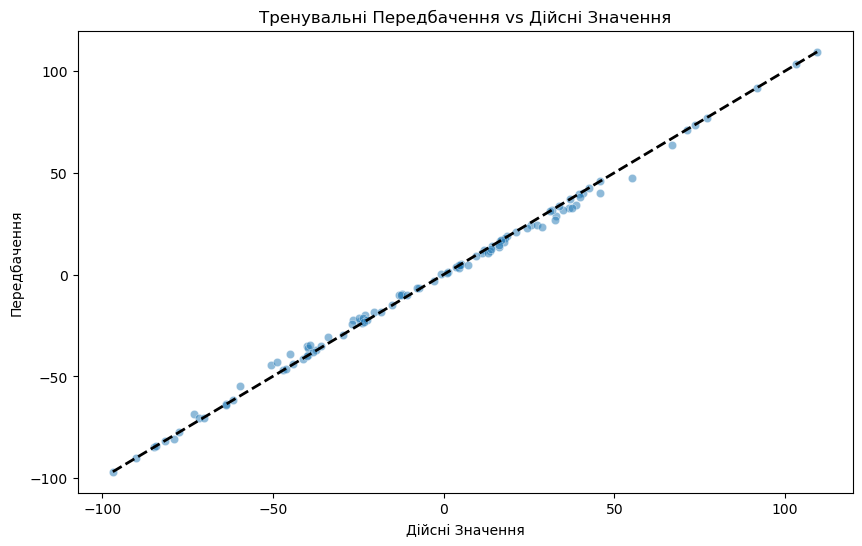

Прогноз та графік для Lasso() на валідаційних даних:
Валідаційні набір даних: Mean Squared Error: 6481605.66
Валідаційні набір даних: Mean Absolute Error: 701.07
Валідаційні набір даних: R-squared: -2616.56


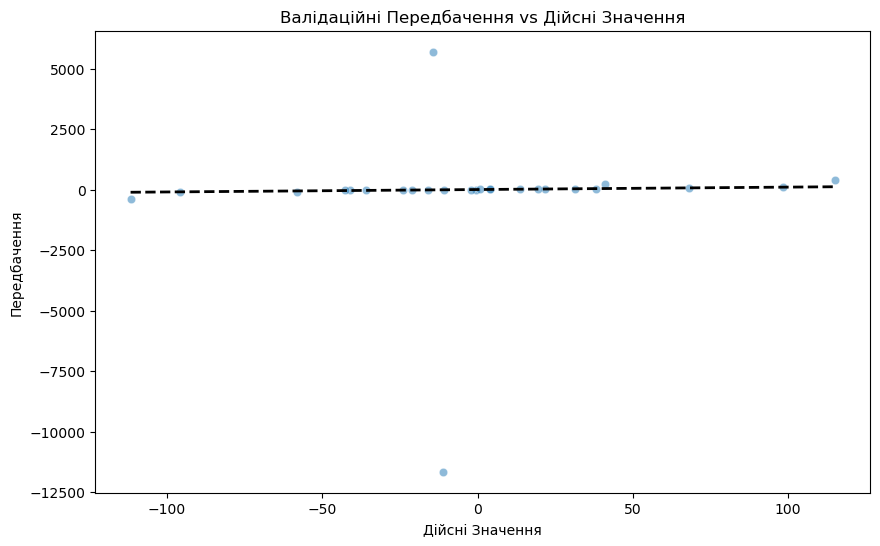

ElasticNet(): {'train': 10.005761, 'val': 3144.660467}

Прогноз та графік для ElasticNet() на тренувальних даних:
Тренувальні набір даних: Mean Squared Error: 100.12
Тренувальні набір даних: Mean Absolute Error: 5.49
Тренувальні набір даних: R-squared: 0.95


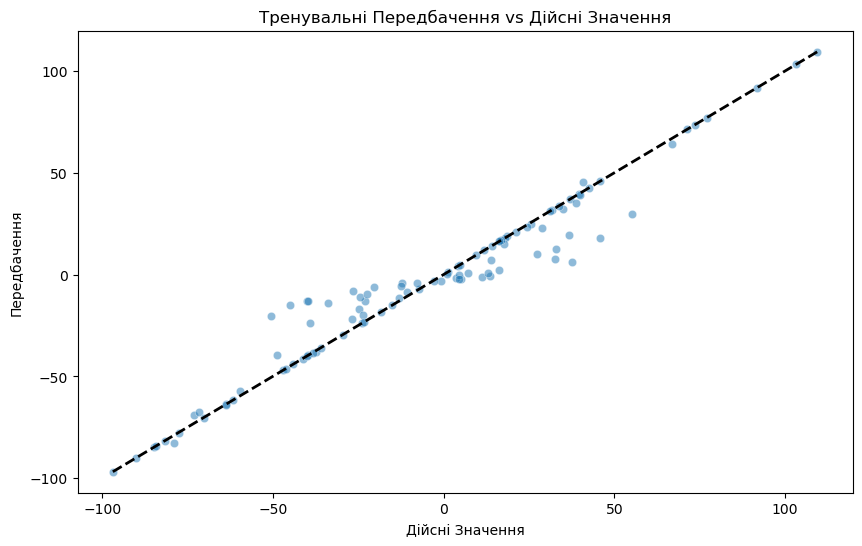

Прогноз та графік для ElasticNet() на валідаційних даних:
Валідаційні набір даних: Mean Squared Error: 9888889.45
Валідаційні набір даних: Mean Absolute Error: 1168.38
Валідаційні набір даних: R-squared: -3992.58


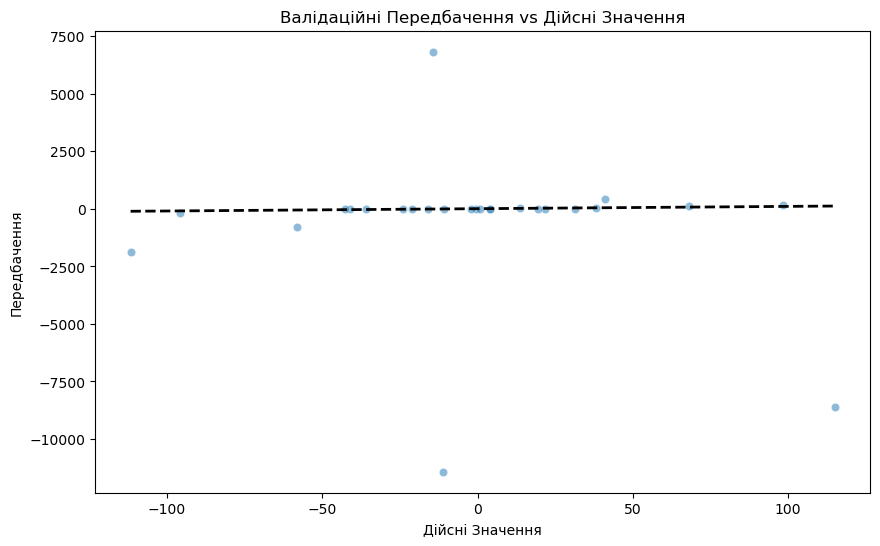

In [33]:
for model in models:
    model.fit(X_train_poly, lin_train_targets)
    eval_results = evaluate_model(model, X_train_poly, lin_train_targets, X_val_poly, lin_val_targets)
    print(f'{str(model)}: {eval_results}\n')
    
    print(f"Прогноз та графік для {str(model)} на тренувальних даних:")
    predict_and_plot(model, X_train_poly, lin_train_targets, 'Тренувальні')
    
    print(f"Прогноз та графік для {str(model)} на валідаційних даних:")
    predict_and_plot(model, X_val_poly, lin_val_targets, 'Валідаційні')

**Висновок:** Для усіх трьох моделей є велика різниця між показниками MAE, MSE та R². Модель добре прогнозує на тренувальних даних і погано на валідаційних. Це свідчить про перенавчання моделі і про те, що вона погано узагальнює. Потрібно визначити які ознаки більше впливають на прогнози моделі. Це може допомогти зрозуміти, які ознаки є шумом.

In [50]:
for model in models:
    coefficients = model.coef_
    feature_names = poly_features.get_feature_names_out(lin_train_inputs.columns)
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)

    print({str(model)}, '\n', feature_importance.head(10), '\n')

{'Ridge()'} 
                         Feature  Coefficient
42484              feature_4^19     0.003793
53109              feature_4^20    -0.003289
53070  feature_3^2 feature_4^18     0.002519
52879    feature_2 feature_4^19    -0.002254
52670  feature_2^2 feature_4^18     0.002103
26316              feature_4^17     0.002084
51339    feature_1 feature_4^19     0.001822
53110    feature_4^19 feature_5    -0.001711
53035  feature_3^4 feature_4^16     0.001635
42275    feature_2 feature_4^18    -0.001383 

{'Lasso()'} 
                      Feature  Coefficient
4                  feature_4    43.374570
784              feature_4^7     0.402043
196              feature_2^5    -0.068418
4366  feature_4 feature_5^10     0.020421
2992            feature_4^10    -0.019075
2982   feature_3 feature_4^9    -0.018727
198    feature_2^4 feature_4     0.018166
378              feature_2^6     0.013093
3002            feature_5^10     0.011528
3993  feature_1 feature_4^10     0.010709 

{'ElasticNe

**Висновок:** 
- Для Ridge: коефіцієнти дуже малі, що вказує на те, що вага майже однакова для усіх ознак. Це можливо і призвело до перенавчання, оскільки важливі ознаки не мали достатньої ваги.

- Для Lasso: модель визначила `feature_4` як найбільш значущу ознаку з дуже високим коефіцієнтом. Далі йде ознака `feature_4^7`. Але усі наступні є практично неважливими і з дуже малими коефіцієнтами. Отже модель в основному зосередилась  на прогнозуванні передбачення на основі ознаки feature_4 та її поліному 7 степеня.

- Для ElasticNet: найбільш значущі ознаки включають поліноми, що включають `feature_4`, `feature_3` та `feature_5`. ElasticNet визначила кілька ключових ознак, але не зменшила жоден із коефіцієнтів до нуля, таким чином модель не змогла виділити більш значущі та взагалі не значущі ознаки.